# Example 1

In [1]:
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sfc import euler_simulation, generate_differential_equations

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format = "retina"  # or "svg"
plt.rcParams.update({'figure.constrained_layout.use':True})

## Describe the model of the economy

```mermaid
graph TD
    %% Define the stocks (sectors)
    Household[Households]
    Firm[Firms]
    Government[Government]

    %% Define the flows between the sectors
    Firm -->|W| Household
    Household -->|C| Firm
    Household -->|T| Government
    Government -->|G| Firm
```

### There are 3 sectors: 
* Households
* Firms
* Government

### There are flows of money between these sectors:
* Households consume: There is a flow of $C$ from the household to firms.
* Firms pay workers: There is a flow of $W$ from firms to households.
* The government taxes: There is a flow of $T$ from households to the government.
* The government spends: There is a flow of $G$ from the government to firms.

This is obviously a highly simplified model of the economy! But this is what we'll start with.

Our task is to encode this model formally. We'll do that in a Godley table.

## Define Godley table


In [4]:
# Define symbolic variables for flows
C, W, T, G = sp.symbols('C W T G')  # Consumption, Wages, Taxes, Government spending

params_symbols = [C, W, T, G]

# Define sectors as columns
sectors = ['Households', 'Firms', 'Government']

# Define a list of flows and their sectoral effects (Households, Firms, Government)
flows = [
    ('Consumption', [-C, C, 0]),       # Households spend (-C), Firms receive (+C)
    ('Wages', [W, -W, 0]),             # Firms pay (-W), Households receive (+W)
    ('Taxes', [-T, 0, T]),             # Households pay (-T), Government receives (+T)
    ('Government Spending', [0, G, -G]) # Government spends (-G), Firms receive (+G)
]

# Create DataFrame from the flows list
godley_table = pd.DataFrame([flow[1] for flow in flows], 
                            columns=sectors, 
                            index=[flow[0] for flow in flows])

godley_table

,Households,Firms,Government
Consumption,-C,C,0
Wages,W,-W,0
Taxes,-T,0,T
Government Spending,0,G,-G


The rows must sum to zero!

In [5]:
assert godley_table.sum(axis=1).eq(0).all()

godley_table.sum(axis=1)

Consumption            0
Wages                  0
Taxes                  0
Government Spending    0
dtype: object

## Generate differential equations

Compute total flows for each sector. These are the sum of the flows in and out of each sector, i.e. the column sums.

In [6]:
household_flow = godley_table['Households'].sum()
firm_flow = godley_table['Firms'].sum()
government_flow = godley_table['Government'].sum()

In [7]:
household_flow

-C - T + W

In [8]:
firm_flow

C + G - W

In [9]:
government_flow

-G + T

Another way to do this is actual differential equations:

In [10]:
t = sp.symbols('t')
diff_eqs = generate_differential_equations(godley_table, t)

In [11]:
diff_eqs["Households"]

Eq(Derivative(S_Households(t), t), -C - T + W)

In [12]:
diff_eqs["Firms"]

Eq(Derivative(S_Firms(t), t), C + G - W)

In [13]:
diff_eqs["Government"]

Eq(Derivative(S_Government(t), t), -G + T)

## Run simulation

We'll use what we defined to simulate the economy, using Euler's method.

In [14]:
initial_values = {
    'Households': 100,
    'Firms': 100,
    'Government': 100,
}

# Define parameters as a dictionary (C, W, T, G) for the simulation
params = {
    C: 10,  # Consumption
    W: 5,   # Wages
    T: 2,   # Taxes
    G: 4    # Government Spending
}

# Run the Euler simulation
stock_df = euler_simulation(diff_eqs, params_symbols, initial_values, params)

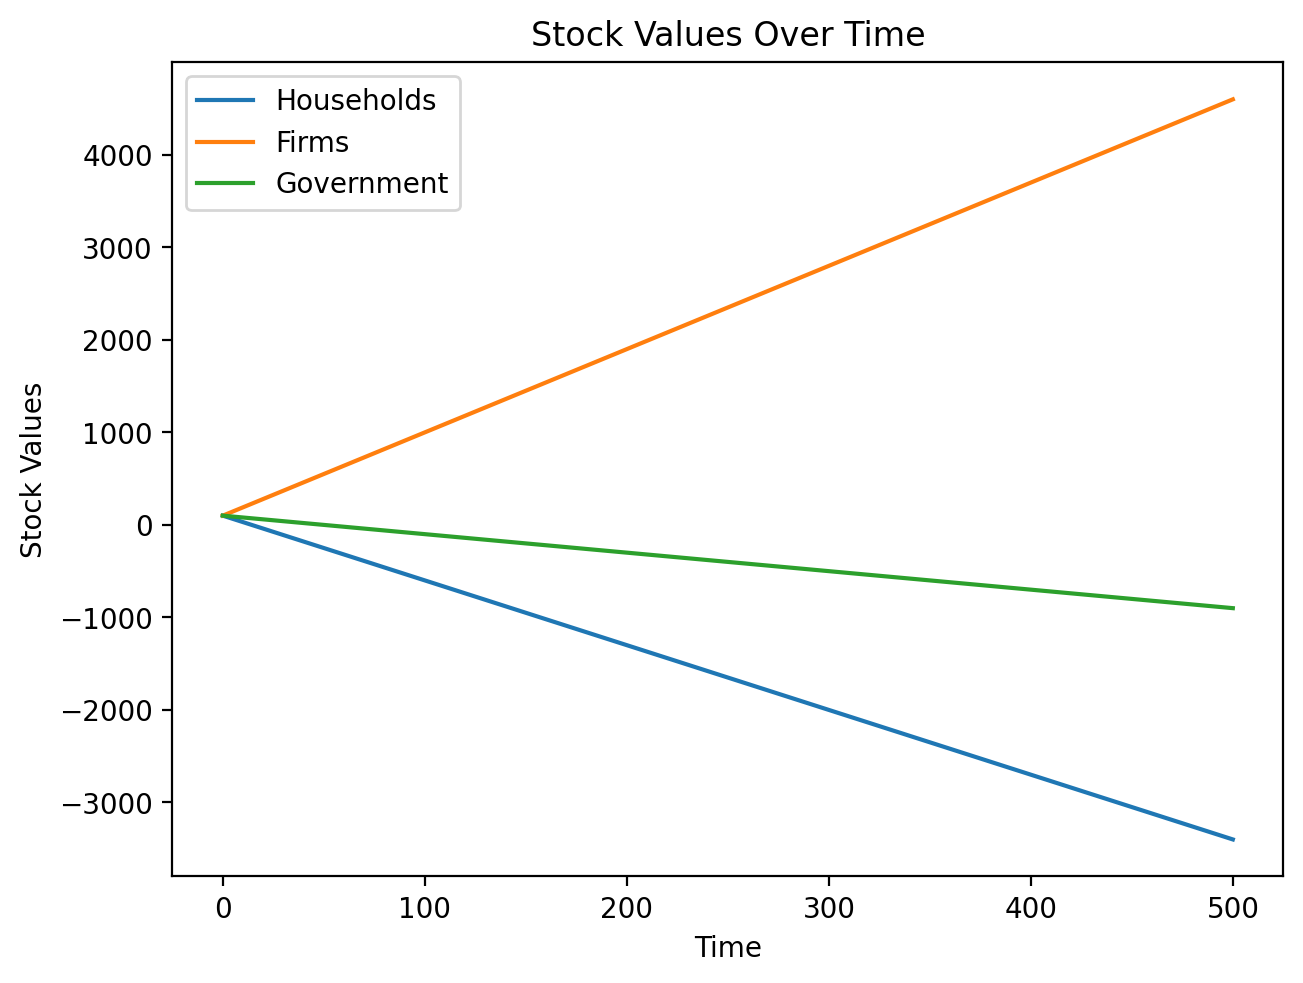

In [15]:
fig, ax = plt.subplots()
    
stock_df.plot(ax=ax)
ax.set(title='Stock Values Over Time', xlabel='Time', ylabel='Stock Values');

The total money in the economy should be constant. We can check this below:

In [16]:
initial_money = sum(initial_values.values())
total_money_over_time = stock_df.sum(axis=1)
np.allclose(initial_money, total_money_over_time)

True